# Download Sentinel-2 data for ASO rasters

Given an ASO raster, find Sentinel-2 scenes over the same area within a week of lidar acqusition, then choose scene with most snow pixels (find max coverage area and least cloud pixels).

In [1]:
# based on exmaples from
# https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/
# https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
import glob
import rioxarray as rxr
import re
import datetime
import pandas as pd
from shapely.geometry import box
import odc.stac

In [2]:
aso_raster_fns = glob.glob('rasters/*')

In [3]:
aso_raster_fn = aso_raster_fns[0]

In [4]:
time = pd.to_datetime(re.search("(\d{4}\d{2}\d{2})", aso_raster_fn).group())
week_before = (time - datetime.timedelta(weeks=1)).strftime('%Y-%m-%d')
week_after = (time + datetime.timedelta(weeks=1)).strftime('%Y-%m-%d')
time_of_interest = f'{week_before}/{week_after}'

In [5]:
aso_raster = rxr.open_rasterio(aso_raster_fn).squeeze()
bounds_latlon = box(*aso_raster.rio.transform_bounds("EPSG:4326"))

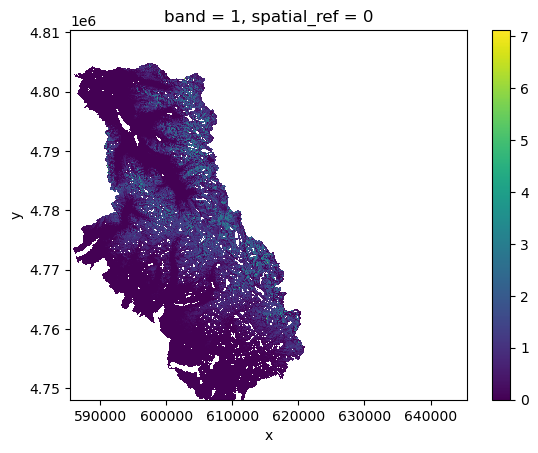

In [6]:
aso_raster.plot()

In [7]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=bounds_latlon,
    datetime=time_of_interest)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 15 Items


In [8]:
sentinel2_stac = odc.stac.load(items,chunks={"x": 2048, "y": 2048},resolution=60)

In [9]:
sentinel2_stac_clipped = sentinel2_stac.rio.clip_box(*bounds_latlon.bounds,crs="EPSG:4326")

/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/srv/conda/envs/notebook/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


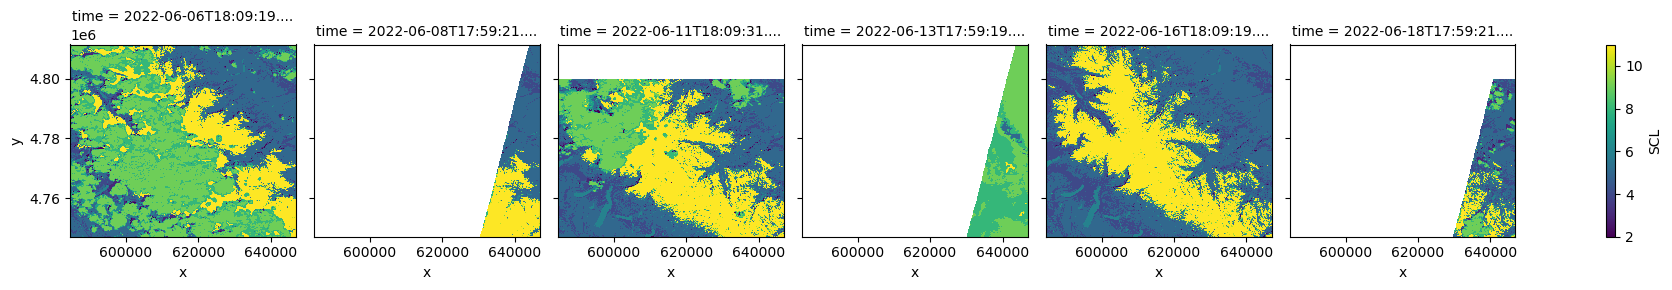

In [10]:
sentinel2_stac_clipped['SCL'].plot(col='time')

In [11]:
scl = sentinel2_stac_clipped['SCL'].rio.reproject_match(aso_raster).where(aso_raster>0)

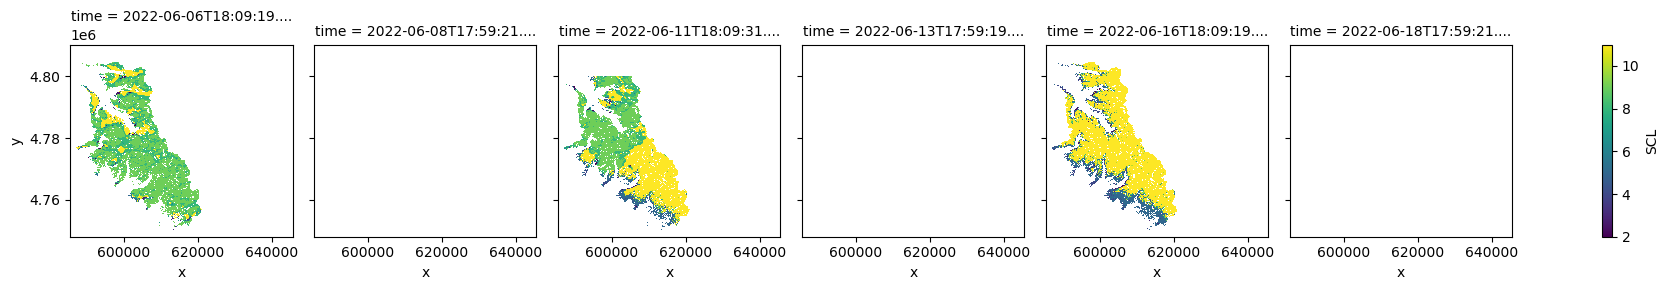

In [12]:
scl.plot(col='time')

In [13]:
classes = [ #SCL classes here: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/
#0,   #No Data (Missing data)	#000000	
#1,   #Saturated or defective pixel	#ff0000	
#2,   #Topographic casted shadows (called "Dark features/Shadows" for data before 2022-01-25)	#2f2f2f	
#3,   #Cloud shadows	#643200	
4,   #Vegetation	#00a000	
5,   #Not-vegetated	#ffe65a	
#6,   #Water	#0000ff	
#7,   #Unclassified	#808080	
#8,   #Cloud medium probability	#c0c0c0	
#9,   #Cloud high probability	#ffffff	
#10,   #Thin cirrus	#64c8ff	
11    #Snow or ice      
]

In [14]:
idx_least_clouds = scl.where(scl.isin(classes)).sum(dim=['x','y']).idxmax()

In [15]:
sentinel2_best_lowcloud = sentinel2_stac_clipped.sel(time=idx_least_clouds)

In [16]:
sentinel2_best_lowcloud

<xarray.Dataset>
Dimensions:      (y: 1072, x: 1038)
Coordinates:
  * y            (y) float64 4.811e+06 4.811e+06 ... 4.747e+06 4.747e+06
  * x            (x) float64 5.847e+05 5.847e+05 ... 6.468e+05 6.469e+05
    time         datetime64[ns] 2022-06-16T18:09:19.024000
    spatial_ref  int64 0
    band         int64 1
Data variables: (12/16)
    AOT          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    B01          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    B02          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    B03          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    B04          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    B05          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    ...           ...
    B11          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    B12          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    B8A          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    SCL          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    WVP          (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>
    visual       (y, x) float32 dask.array<chunksize=(571, 637), meta=np.ndarray>

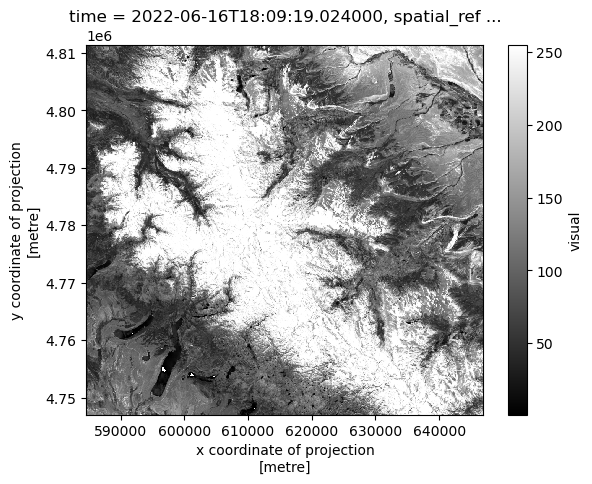

In [17]:
sentinel2_best_lowcloud['visual'].plot(cmap='gray')

In [18]:
sentinel2_best_lowcloud.to_netcdf(f'sentinel2_data/S2_{pd.to_datetime(idx_least_clouds.values).strftime("%Y%m%d")}_for_{aso_raster_fn[8:-4]}.nc')